# Rocket event analysis

This is a menu-driven workflow to examine the seismic data in the Rocketevents directory in Dropbox and measure PGV and PGA values

In [73]:
dropboxpath = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3 Project Documents/201602 Rocket Seismology/db/wfdata/rocketevents'
import os, glob
from obspy import read, Stream
import numpy as np

def peak_vector_amplitude(st):
    #ids = []
    stations = []
    m = []
    for tr in st:
        #ids.append(tr.id)
        stations.append(tr.stats.station)
    unique_stations = sorted(set(stations))
    good_stations = []
    for sta in unique_stations: # set gets unique values from list, but sorted turns back to a list
        st_sta = st.copy().select(station=sta)
        st_sta = st_sta.select(channel='[BHES]H[ZNE12]')
        #print(st_sta)
        if len(st_sta)==3:
            y1 = st_sta[0].data
            y2 = st_sta[1].data
            y3 = st_sta[2].data
            y = np.sqrt(np.square(y1) + np.square(y2) + np.square(y3))
            m.append(max(y))
            good_stations.append(sta)
    return (m, good_stations)
    
# Menu of events - choose event
#os.listdir(dropboxpath)
os.chdir(dropboxpath)
eventdirs = sorted(glob.glob("20*"))
print("Select event: ")
c=1
for eventdir in eventdirs:
    print("%d:\t%s" % (c, eventdir))
    c+=1
choice = input("\nChoice ?  ")

eventdir = eventdirs[int(choice)-1]
print('You chose %s' % eventdir)
masterfile = os.path.join(eventdir, 'masterwaveformdata.mseed')
if os.path.exists(masterfile):
    st = read(masterfile)
else:


    # Load any seismo-acoustic data we can find in the event folder
    st = Stream()

    for root, dirs, files in os.walk(eventdir, topdown=False):
    
        for name in files:
            thisfullpath = os.path.join(root, name)
            if thisfullpath.lower().find('soh')==-1 and thisfullpath.lower().find('txt')==-1:
                print(thisfullpath)
                try:
                    this_st = read(thisfullpath)
                except:
                    pass
                else:
                    for tr in this_st:
                        if tr.stats.sampling_rate>=50:
                            tr.detrend()
                            if tr.stats.channel[1]=='H': # a seismic channel
                                # trace is in counts. there are 0.3 counts/ (nm/s).
                                tr.data = tr.data / 0.3 * 1e-9 # now in m/s
                            st.append(tr)
            
    # Master the data we have found for this event
    if st:
        st.merge()
        if st.select(station='BCHH') and st.select(station='CARL0'):
            stgood = Stream()
            for tr in st:
                if tr.stats.station != 'CARL0':
                    stgood.append(tr)
            st = stgood 
    
        # Save data
        st.write(masterfile)
        
if st: 
    # Plot velocity seismogram
    vpngfile = os.path.join(eventdir, 'velocity_seismogram.png')
    if not os.path.exists(vpngfile):
        st.plot(equal_scale=False, outfile=vpngfile)
    
    # Display PGV
    print('PGV values:')      
    (m, stations) = peak_vector_amplitude(st)
    for c in range(len(stations)):
            print('%s:\t%f m/s' % (stations[c], m[c]))            
    
    # Plot acceleration seismogram
    st.differentiate()
    apngfile = os.path.join(eventdir, 'acceleration_seismogram.png')
    if not os.path.exists(apngfile):
        st.plot(equal_scale=False, outfile=apngfile)
    
    # Display PGA
    print('PGA values:')
    (m, stations) = peak_vector_amplitude(st)
    for c in range(len(stations)):
            print('%s:\t%f m/s^2' % (stations[c], m[c]))
            
    # Note that this workflow does not correct the infrasound data channels: they are still in counts. 
    # And PGV and PGA values for infrasound channels are meaningless
    


Select event: 
1:	20160205_ULA_Atlas_V
2:	20160229_SpaceX_Falcon9_Abort
3:	20160304_SpaceX_Falcon9
4:	20160322_ULA_Atlas_V
5:	20160405_SpaceX_Falcon9_Static
6:	20160408_SpaceX_Falcon9
7:	20160611
8:	20160615
9:	20160624
10:	20160814_SpaceX_Falcon9
11:	20160819_ULA_Delta_IV
12:	20160901_SpaceXplosion
13:	20160908_ULA_Atlas_V
14:	20170121
15:	20170418_launch
16:	20170508_WHATIsit
17:	20170603
18:	20170818_launch
19:	20170822_sonic_tests
20:	20170826_minotaur
21:	20170831_static
22:	20170907_spacex
23:	20171114_whatisthis
24:	20171206_static_test
25:	20180108
26:	20180120
27:	20180131
28:	20180206_FalconHeavyLaunch
29:	20180301_AtlasV
30:	20180306_SpaceX_Falcon9
31:	20180402_Falcon9
32:	20180414_AtlasV
33:	20180418_Falcon9
34:	20180511_Falcon9
35:	20180604_Falcon9
36:	20180629_Falcon9
37:	20180722_Falcon9
38:	20180807_Falcon9
39:	20190527
40:	20190625
41:	20190625_FalconHeavy3

Choice ?  41
You chose 20190625_FalconHeavy3
PGV values:


ValueError: operands could not be broadcast together with shapes (16000264,) (16000485,) 

28.70226315789473


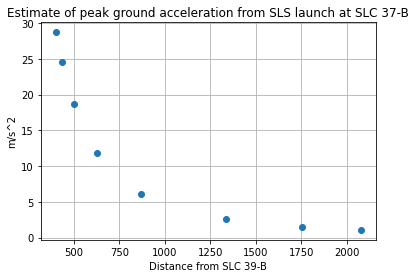

In [71]:
# PGA from 2016/03/04 Falcon 9 launch at BCHH was 0.51 ms^2 (vector amplitude).
# This was at distance 0.85 miles, and thrust of 7.6 x 10^6 N.
# Proposed linear array at 37-B would be 0.25 - 1.3 miles
# thrust of SLS would be 37.0 x 10^6 N.
# What PGA would we expect at a distance of 0.25 miles?

# Assume r^2 decay:
thrust_ratio = 3.7e7/7.6e6
distance_ratio = 0.25**2/0.85**2
PGA_estimated = 0.51 * thrust_ratio / distance_ratio
print(PGA_estimated)
distances = [0.25, 0.27, 0.31, 0.39, 0.54, 0.83, 1.09, 1.29]
PGA_estimates = PGA_estimated * 0.25**2 / np.square(distances)
import matplotlib.pyplot as plt
plt.plot(np.array(distances)*1609, PGA_estimates,'o')
plt.ylabel('m/s^2')
plt.xlabel('Distance from SLC 39-B')
plt.title('Estimate of peak ground acceleration from SLS launch at SLC 37-B')
plt.grid('on')

In [72]:
print(thrust_ratio)

4.868421052631579


In [81]:
dropboxpath = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3 Project Documents/201602 Rocket Seismology/db/wfdata/rocketevents'
import os, glob
from obspy import read, Stream
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


os.chdir(dropboxpath)
eventdirs = sorted(glob.glob("20*"))
for eventdir in eventdirs:


    masterfile = os.path.join(eventdir, 'masterwaveformdata.mseed')
    if os.path.exists(masterfile):
        st = read(masterfile)
    else:

        # Load any seismo-acoustic data we can find in the event folder
        st = Stream()

        for root, dirs, files in os.walk(eventdir, topdown=False):
    
            for name in files:
                thisfullpath = os.path.join(root, name)
                if thisfullpath.lower().find('soh')==-1 and thisfullpath.lower().find('txt')==-1:
                    print(thisfullpath)
                    try:
                        this_st = read(thisfullpath)
                    except:
                        pass
                    else:
                        for tr in this_st:
                            if tr.stats.sampling_rate>=50:
                                tr.detrend()
                                if tr.stats.channel[1]=='H': # a seismic channel
                                    # trace is in counts. there are 0.3 counts/ (nm/s).
                                    tr.data = tr.data / 0.3 * 1e-9 # now in m/s
                                st.append(tr)
            
        # Master the data we have found for this event
        if st:
            for tr in st:
                if tr.stats.station == 'CARL0':
                    tr.stats.station = 'BCHH'
            #st.merge()
            #if st.select(station='BCHH') and st.select(station='CARL0'):
                #stgood = Stream()
                #for tr in st:
                    #if tr.stats.station != 'CARL0':
                        #stgood.append(tr)
                #st = stgood 
    
            # Save data
            print(st.__str__(extended=True))
            st.write(masterfile)


            
        
          
            
            
    if st: 
        # select start and end points
        st.plot()
        plt.show()
        x = plt.ginput(2) 
        
        st.trim(starttime = x[0], endtime = x[1])

        
        
        
        # Plot velocity seismogram
        vpngfile = os.path.join(eventdir, 'velocity_seismogram.png')
        if not os.path.exists(vpngfile):
            st.plot(equal_scale=False, outfile=vpngfile)
    
        # Display PGV
        print('PGV values:')      
        (m, stations) = peak_vector_amplitude(st)
        for c in range(len(stations)):
            print('%s:\t%f m/s' % (stations[c], m[c]))            
    
        # Plot acceleration seismogram
        st.differentiate()
        apngfile = os.path.join(eventdir, 'acceleration_seismogram.png')
        if not os.path.exists(apngfile):
            st.plot(equal_scale=False, outfile=apngfile)
    
        # Display PGA
        print('PGA values:')
        (m, stations) = peak_vector_amplitude(st)
        for c in range(len(stations)):
            print('%s:\t%f m/s^2' % (stations[c], m[c]))
            
        a = input('any key to continue')
            
    # Note that this workflow does not correct the infrasound data channels: they are still in counts. 
    # And PGV and PGA values for infrasound channels are meaningless
    

TclError: 

In [78]:
from obspy.core.utcdatetime import UTCDateTime
st = read(masterfile)
st.trim(starttime=UTCDateTime(2016,2,5,13,36,0), endtime=UTCDateTime(2016,2,5,13,45,0))
st.plot()

FileNotFoundError: [Errno 2] No such file or directory: '20170822_sonic_tests/masterwaveformdata.mseed'